In [ ]:
라이브러리 임포트

In [1]:
from PIL import Image
from skimage.io import imread, imshow, show
from scipy import ndimage, misc, signal, fftpack

from skimage.color import rgb2gray

import matplotlib.pylab as pylab
import numpy as np
import numpy.fft as fp
import timeit

In [2]:
# 역자 수정
# scipy 1.1 버전부터 signaltonoise() 함수 제공되지 않음
# 아래 함수 구현으로 사용함 

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

# Low-pass filter

푸리에 가우시안 LPF

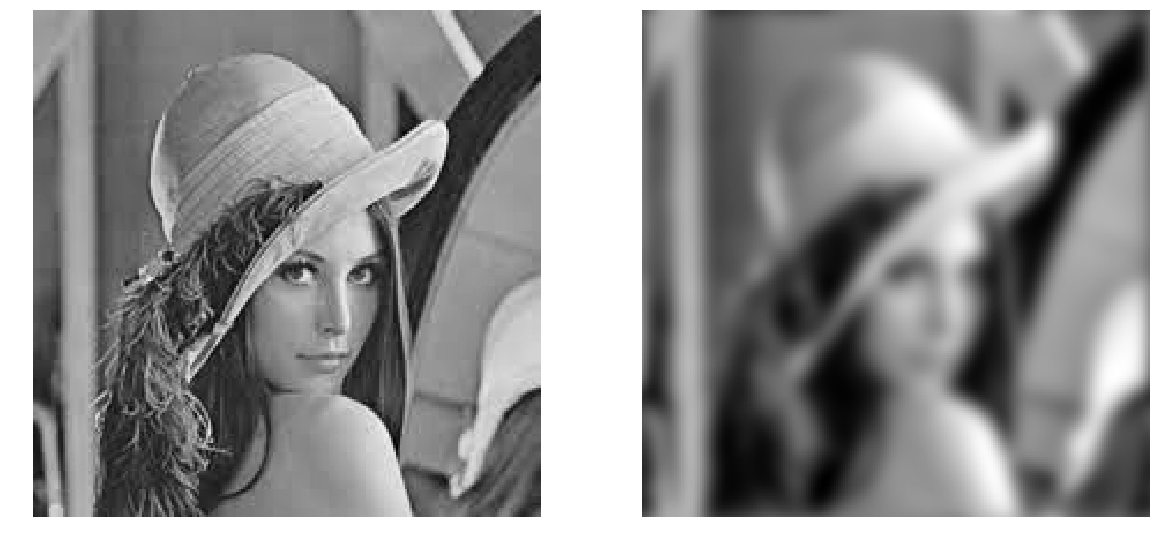

In [7]:
im = np.mean(imread('../images/lena.jpg'), axis=2)  
freq = fp.fft2(im)
freq_gaussian = ndimage.fourier_gaussian(freq, sigma=4)
im1 = fp.ifft2(freq_gaussian)

fig, (axes1, axes2) = pylab.subplots(1, 2, figsize=(20,10))
pylab.gray() 
axes1.imshow(im), axes1.axis('off')
axes2.imshow(im1.real), axes2.axis('off')
pylab.show()

C:\Users\bae22\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


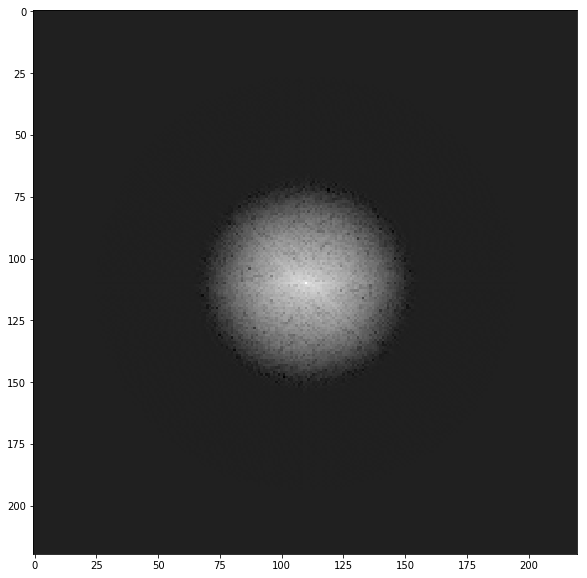

In [14]:
mag = 20*np.log10( 0.1 + fp.fftshift(freq_gaussian))
pylab.figure(figsize=(10,10))
pylab.imshow( mag.astype(int))
pylab.show()

In [ ]:
scipy fftpack로 LPF 수행

2.389151856495428


C:\Users\bae22\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


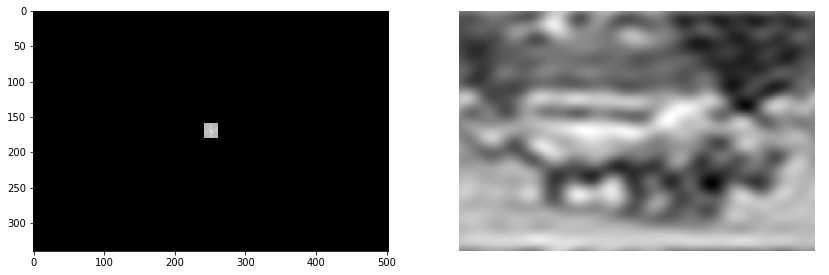

In [28]:
im = np.array(Image.open('../images/rhino.jpg').convert('L')) 

freq = fp.fft2(im)									# FFT 수행
freq1 = np.copy(freq)
freq2 = fp.fftshift(freq1)							# shift 수행
freq2_low = np.copy(freq2)

(w, h) = freq.shape
half_w, half_h = w//2, h//2								# 중심 좌표
freq2_low[half_w-10:half_w+11,half_h-10:half_h+11] = 0 	# 저주파 영역 계수 제거
freq2 -= freq2_low  									# 저주파 영역만 살림

im1 = fp.ifft2(fp.ifftshift(freq2)).real				# IFFT 수행 및 실수부 가져옴	
print(signaltonoise(im1, axis=None))    				 # 2.389151856495427

pylab.figure(figsize=(14,10))
pylab.subplot(1,2,1), pylab.imshow( (20*np.log10( 0.1 + freq2)).astype(int))
pylab.subplot(1,2,2), pylab.imshow(im1, cmap='gray'), pylab.axis('off')
pylab.show()

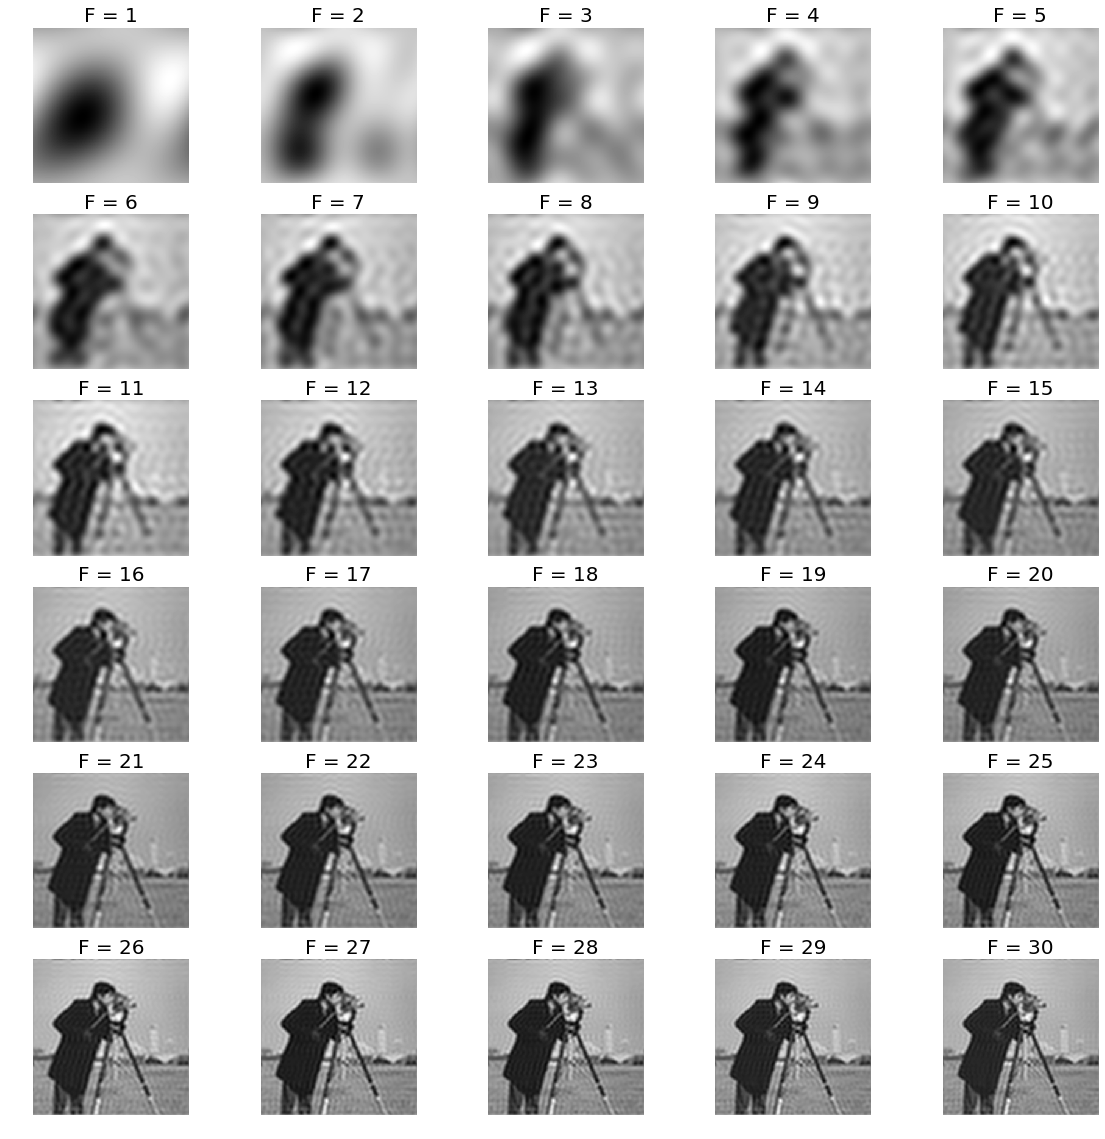

In [34]:
im = np.array(Image.open('../images/cameraman.jpg').convert('L'))
freq = fp.fft2(im)
(w, h) = freq.shape
half_w, half_h = int(w/2), int(h/2)
snrs_lp = []
ubs = list(range(1,31))

pylab.figure(figsize=(20,20))
for u in ubs:
    freq2 = fp.fftshift(np.copy(freq))
    freq2_low = np.copy(freq2)
    freq2_low[half_w-u:half_w+u+1,half_h-u:half_h+u+1] = 0
    freq2 -= freq2_low                             # 저주파 영역만 선택
    
    im1 = fp.ifft2(fp.ifftshift(freq2)).real
    snrs_lp.append(signaltonoise(im1, axis=None))
    
    pylab.subplot(6,5,u), pylab.imshow(im1, cmap='gray'), pylab.axis('off')
    pylab.title('F = ' + str(u), size=20)
    pylab.subplots_adjust(wspace=0.1, hspace=0.2)
pylab.show()

In [ ]:
SNR 변화 그래프

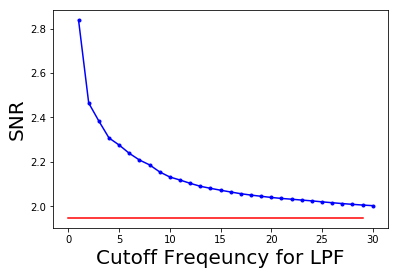

In [43]:
snr = signaltonoise(im, axis=None)   

pylab.plot(ubs, snrs_lp, 'b.-')
pylab.plot(range(30), [snr]*30, 'r-')
pylab.xlabel('Cutoff Freqeuncy for LPF', size=20)
pylab.ylabel('SNR', size=20)
pylab.show()

DoG를 사용한 밴드 패스 필터

0.7862192363545747


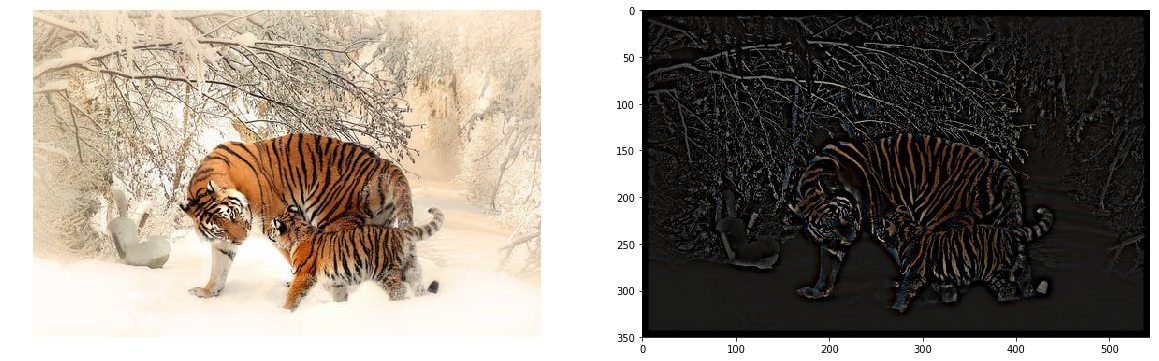

In [8]:
from skimage import img_as_float

im = img_as_float(pylab.imread('../images/tigers.jpeg'))
x = np.linspace(-10, 10, 15)

kernel_1d = np.exp(-0.005*x**2)
kernel_1d /= np.trapz(kernel_1d) # 전체합이 1이 되도록 정규화 
gauss_kernel1 = kernel_1d[:, np.newaxis] * kernel_1d[np.newaxis, :]

kernel_1d = np.exp(-5*x**2)
kernel_1d /= np.trapz(kernel_1d)  # 정규화
gauss_kernel2 = kernel_1d[:, np.newaxis] * kernel_1d[np.newaxis, :]

DoGKernel = gauss_kernel1[:, :, np.newaxis] - gauss_kernel2[:, :, np.newaxis]
im1 = signal.fftconvolve(im, DoGKernel, mode='same')
print(np.max(im1))

pylab.figure(figsize=(20,10))
pylab.subplot(1,2,1), pylab.imshow(im), pylab.axis('off')
pylab.subplot(1,2,2), pylab.imshow(np.clip(im1, 0, 1)) 
pylab.show()

In [ ]:
Band-stop (notch) filter

C:\Users\bae22\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
C:\Users\bae22\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


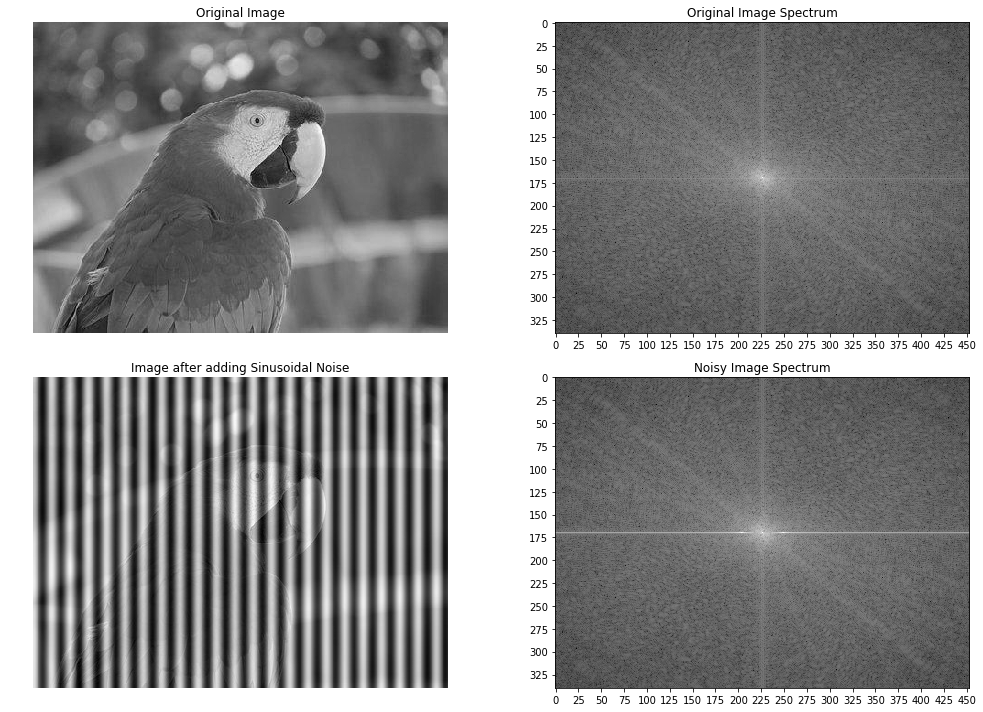

In [3]:
im =  np.mean(imread("../images/parrot.png"), axis=2) / 255
im1 = np.copy(im)
for n in range(im.shape[1]):
    im1[:, n] += np.cos(0.1*np.pi*n)

F1 = fftpack.fft2((im).astype(float))
F2 = fftpack.fftshift( F1 )
F3 = fftpack.fft2((im1).astype(float)) # noisy spectrum
F4 = fftpack.fftshift( F3 )

mag1 = (20*np.log10( 0.1 + F2)).astype(int)
mag2 = (20*np.log10( 0.1 + F4)).astype(int)

pylab.figure(figsize=(15,10))
pylab.subplot(2,2,1), pylab.imshow(im, cmap='gray'), pylab.axis('off')
pylab.title('Original Image')

pylab.subplot(2,2,2), pylab.imshow( mag1, cmap='gray')
pylab.xticks(np.arange(0, im.shape[1], 25))
pylab.yticks(np.arange(0, im.shape[0], 25))
pylab.title('Original Image Spectrum')

pylab.subplot(2,2,3), pylab.imshow(im1, cmap='gray'), pylab.axis('off')
pylab.title('Image after adding Sinusoidal Noise')

pylab.subplot(2,2,4), pylab.imshow( mag2, cmap='gray')
pylab.xticks(np.arange(0, im.shape[1], 25))
pylab.yticks(np.arange(0, im.shape[0], 25))
pylab.title('Noisy Image Spectrum')
pylab.tight_layout()
pylab.show()

C:\Users\bae22\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


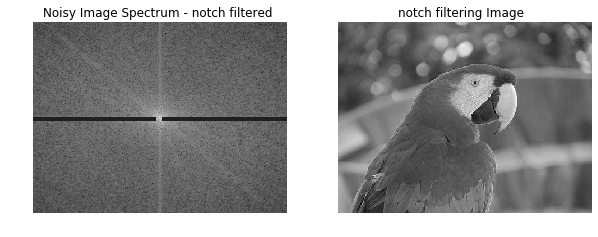

In [13]:
F4[170:176,:220] = F4[170:176,230:] = 0   # 잡음 가장 많이 일으킬 가능성이있는 주파수 제거

mag2 = (20*np.log10( 0.1 + F4)).astype(int)
im1 = fftpack.ifft2(fftpack.ifftshift( F4 )).real

pylab.figure(figsize=(10,5))
pylab.subplot(1,2,1), pylab.imshow(mag2, cmap='gray'), pylab.axis('off')
pylab.title('Noisy Image Spectrum - notch filtered ')
pylab.subplot(1,2,2), pylab.imshow(im, cmap='gray'), pylab.axis('off')
pylab.title('notch filtering Image  ')
pylab.show()